In [5]:
import os

import numpy as np
from numpy import random
import pandas as pd
import glob
import math
import tqdm
import tabulate

import torch
import matplotlib.pyplot as plt

from diffusion.data_util import get_ckpt_path, show_out_images, get_logger_path, train_plot, img_plot
from diffusion.script_util import ModelType, VarType
from diffusion.lightning_modules import DiffusionWithModel, MNISTDataModule
from diffusion.vgg5 import VGG5
from diffusion.vae import SimpleVAE

In [13]:
batch_size = 64
stage = 'fit' # fit|test

device = 'cuda' if torch.cuda.is_available() else 'cpu'

work_dir = r'C:\Users\niels\local_data\bachelor'
data_dir = os.path.join(work_dir, 'datasets')
models_dir = os.path.join(work_dir, 'models')

data_module = MNISTDataModule(data_dir, batch_size)
data_module.prepare_data()
data_module.setup(stage)
if stage == 'fit':
    dataloader = iter(data_module.val_dataloader())
elif stage == 'test':
    dataloader = iter(data_module.test_dataloader())

get_model_paths = lambda dir: glob.glob(os.path.join(models_dir, dir, '*.ckpt'), recursive=True)

In [14]:
model_dir = r'uncond-learned-42\lightning_logs\version_0\checkpoints'
model_paths = get_model_paths(model_dir)
model_paths

['C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\epoch-epoch=104-val_loss=0.01308.ckpt',
 'C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\last-epoch=108-val_loss=0.01269.ckpt',
 'C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\last.ckpt',
 'C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\loss-epoch=101-val_loss=0.01267.ckpt',
 'C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\loss-epoch=108-val_loss=0.01269.ckpt',
 'C:\\Users\\niels\\local_data\\bachelor\\models\\uncond-learned-42\\lightning_logs\\version_0\\checkpoints\\loss-epoch=85-val_loss=0.01271.ckpt']

In [15]:
model_path = os.path.join(work_dir, 'eval_models', 'uncond_ddpm.ckpt')
classifier_path = os.path.join(work_dir, 'eval_models', 'classifier.ckpt')
vae_path = os.path.join(work_dir, 'eval_models', 'vae.ckpt')
classifier = VGG5.load_from_checkpoint(classifier_path).to(device).eval()
vae = SimpleVAE.load_from_checkpoint(vae_path).to(device).eval()

plot_path = './plots/'

combined = DiffusionWithModel.load_from_checkpoint(model_path).to(device)
model, diffusion = combined.extract_models()

c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.4, which is newer than your current Lightning version: v1.9.3
  rank_zero_warn(


# sample

In [6]:
n_samples = 100

y = torch.sort(torch.arange(n_samples, device=device) % 10).values if model.model_type is ModelType.cond_embed else None
x, y = diffusion.sample(model, n_samples=n_samples, y=y, to_img=False)

out = classifier(x)
preds = out.detach().cpu().numpy().argmax(1)
# if model.model_type is ModelType.cond_embed:
#     y = y.detach().cpu().numpy()
#     titles = [f'C: {t}, P: {p}' for p, t in zip(preds, y)]
# else:
#     titles = preds
titles = preds
if model.model_type is ModelType.uncond:
    sort_idxs = np.argsort(preds)
    x = x[sort_idxs]
    titles = titles[sort_idxs]
show_out_images(x, titles)

if model.model_type is ModelType.cond_embed:
    plt.savefig(plot_path + 'cond_large_sample', bbox_inches='tight')
else:
    plt.savefig(plot_path + 'uncond_large_sample', bbox_inches='tight')

KeyboardInterrupt: 

In [ ]:
# test sampling label bias
n_samples = 64
n_tests = 16

all_preds = list()

if (model.model_type is ModelType.uncond) and False:
    for _ in tqdm.trange(n_tests):
        x, _ = diffusion.sample(model, n_samples=n_samples, to_img=False, show_pbar=False)
        out = classifier(x)
        preds = out.detach().cpu().numpy().argmax(1)
        all_preds.append(preds)

    all_preds = np.concatenate(all_preds).flatten()
    label, counts = np.unique(all_preds, return_counts=True)
    
    procent = counts / counts.sum()
    
    table = tabulate.tabulate([counts.astype(int).tolist(), procent], headers=label, tablefmt='simple', floatfmt='.3f', intfmt='g')
    latex_table = tabulate.tabulate([counts.astype(int).tolist(), procent], headers=label, tablefmt='latex', floatfmt='.3f', intfmt='g')
    print(table.replace('.000', ''))
    print(latex_table.replace('.000', ''))
    from scipy.stats import chisquare

    print(chisquare(counts, f_exp=counts.sum() / 10))

# gradual sample

## select img

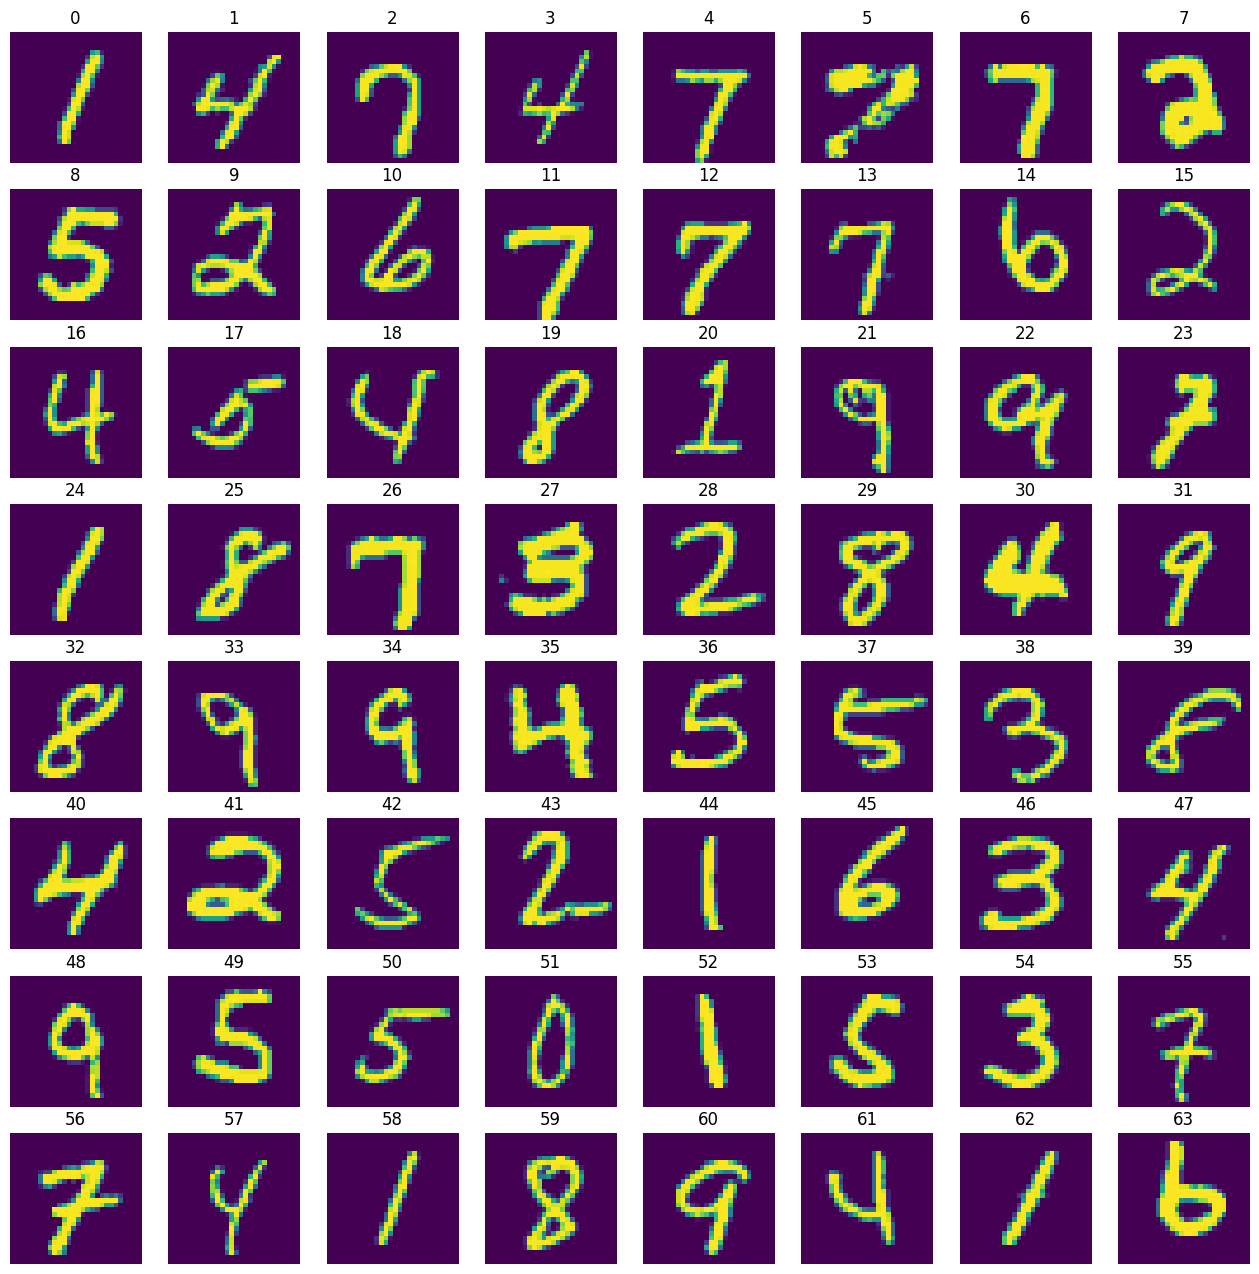

In [7]:
batch_x, batch_y = next(dataloader)
show_out_images(batch_x, torch.arange(batch_size))

In [8]:
idx = 60
x, y = batch_x[idx][None, ...].to(device), batch_y[idx].to(device)

## forward- and reverse process

In [ ]:
img_shape = (1, 1, 28, 28)
n_steps = 10 # how many diffusion steps in plots
size = 2 # img side size
n_samples = 16 # uncond samples from same start (last plot)

torch.manual_seed(0)

# forward
fig = plt.figure(figsize=(size*n_steps, 1.2*size))
fig.suptitle('Forward process (Set noise, calculated)', size=16)

timesteps = torch.linspace(-1, diffusion.num_diffusion_timesteps-1, n_steps, dtype=int, device=device)
noise = torch.randn(img_shape, device=device)

for i, t in enumerate(timesteps, start=1):
    ax = fig.add_subplot(1, n_steps, i)
    if t == -1:
        x_t = x
    else:
        x_t, _ = diffusion.q_sample(x, t, noise)
    img_plot(x_t.squeeze(), int(t)+1, ax)

plt.savefig(plot_path + 'forward_process_calculated', bbox_inches='tight')
plt.show()

# forward gradual method
fig = plt.figure(figsize=(size*n_steps, 1.2*size))
fig.suptitle('Forward process (Gradually noised)', size=16)

x_t = x
i = 1
ax = fig.add_subplot(1, n_steps, i)
img_plot(x_t.squeeze(), 0, ax)
for t in torch.arange(0, diffusion.num_diffusion_timesteps, dtype=int, device=device):
    x_t = diffusion.forward_step(x_t, t)
    if t in timesteps:
        i += 1
        ax = fig.add_subplot(1, n_steps, i)
        img_plot(x_t.squeeze(), int(t)+1, ax)

plt.savefig(plot_path + 'forward_process_gradual', bbox_inches='tight')
plt.show()


In [ ]:
# reverse
torch.manual_seed(0)
fig = plt.figure(figsize=(size*n_steps, 1.2*size))
fig.suptitle('Reverse process (unconditional)', size=16)

x_t, _ = diffusion.q_sample(x, timesteps[-1], noise)
img_start = [x_t]
ax = fig.add_subplot(1, n_steps, n_steps)
img_plot(x_t.squeeze(), int(t)+1, ax)
timesteps_reversed = reversed(timesteps)
for i, (t_lower, t_upper) in tqdm.tqdm(enumerate(zip(timesteps_reversed[1:], timesteps_reversed[:-1]), start=1), total=n_steps-1):
    x_t = diffusion.p_sample_loop(model, t_lower, t_upper, x_t)
    ax = fig.add_subplot(1, n_steps, n_steps-i)
    img_start.append(x_t)
    img = x_t.clamp(0, 1) if int(t_lower)+1 == 0 else x_t
    img_plot(img.squeeze(), int(t_lower)+1, ax)

plt.savefig(plot_path + 'reverse_process', bbox_inches='tight')
plt.show()

In [ ]:
# uncond sample same start
n_rows = 2

torch.manual_seed(0)
multiplot_side = math.sqrt(n_samples)
fig = plt.figure(figsize=(multiplot_side*size*n_steps/n_rows, n_rows*multiplot_side*size))
fig.suptitle('Reverse process (same start)', size=16)

subfigs = fig.subfigures(n_rows, math.ceil(n_steps/n_rows)).flatten()

zero = torch.tensor(0, device=device)
for i, (figure, x_t, t_upper) in tqdm.tqdm(enumerate(zip(subfigs, reversed(img_start), timesteps), start=1), total=n_steps):
    figure.suptitle(int(t_upper)+1)
    if i == 1:
        t_upper = t_upper + 1
    x_t_batch = torch.cat([x_t.clone() for _ in range(n_samples-1)])
    x_t_batch = diffusion.p_sample_loop(model, zero, t_upper, x_t_batch)
    x_t_batch = torch.cat((x_t, x_t_batch.clamp(0, 1)))
    if i == 1:
        x_t_batch = x_t_batch.clamp(0, 1)
    show_out_images(x_t_batch, fig=figure)

plt.savefig(plot_path + 'reverse_process_multirun', bbox_inches='tight')
plt.show()

In [7]:
# variance vs timestep graphs
dir = './fid_vs_timestep_results/'
timestep = np.load(dir + 'timesteps.npy')
accuracy = np.load(dir + 'prediction_accuracy.npy')
fvaeds = np.load(dir + 'fvaed.npy')
pixel_distance = np.load(dir + 'pixel_distance.npy')

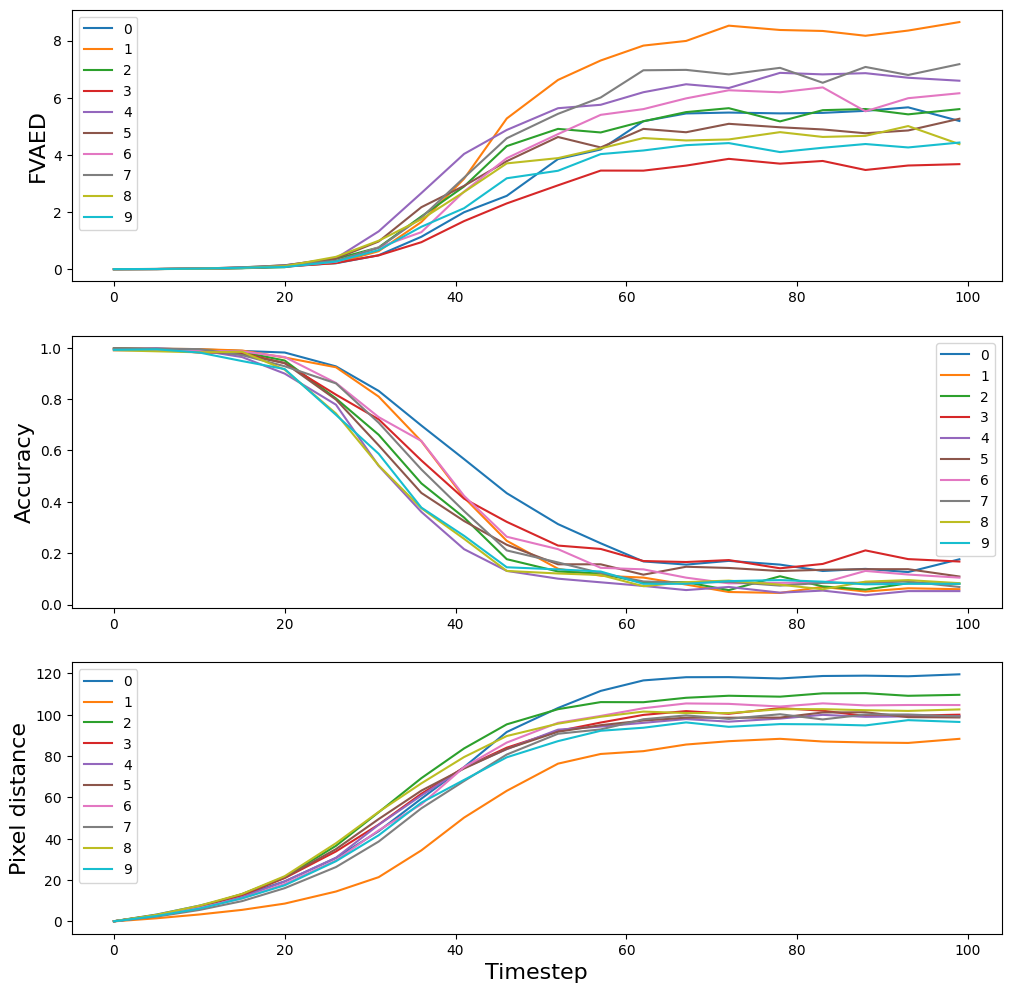

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.set_ylabel('FVAED', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax3.set_ylabel('Pixel distance', size=16)
ax3.set_xlabel('Timestep', size=16)

for label in range(10):
    ax1.plot(timestep, fvaeds[label], label=label)
    ax2.plot(timestep, accuracy[label], label=label)
    ax3.plot(timestep, pixel_distance[label], label=label)

ax1.legend()
ax2.legend()
ax3.legend()

plt.savefig(plot_path + 'variance_vs_timestep_extra', bbox_inches='tight')
plt.show()